In [5]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *

In [6]:
torch.cuda.set_device(6)

In [7]:
dbunch_feat = get_3d_dbunch_feat(Meta.df_any, path_feat256, bs=64)

In [8]:
x,y = dbunch_feat.one_batch()
x.shape, y.shape

(torch.Size([64, 60, 512, 8, 8]), torch.Size([64, 60, 6]))

## Model

https://pytorch.org/tutorials/beginner/transformer_tutorial.html

In [9]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [10]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048
        self.conv = nn.Sequential(
            ConvLayer(512, 1024, stride=2),
            ConvLayer(1024, 1024, stride=2),
            ConvLayer(1024, d_model, stride=2),
            nn.AdaptiveAvgPool2d(1),
            Flatten()
        )
        self.hook = ReshapeBodyHook(self.conv)
        
        n_head = 4
        encoder_layers = TransformerEncoderLayer(d_model*2, n_head, d_model*4)
        self.transformer = TransformerEncoder(encoder_layers, 4)
        
        self.head = nn.Sequential(
#             nn.Linear(d_model*2,d_model),
#             nn.ReLU(),
            nn.Linear(d_model*2,6)
        )
        
    def forward(self, x):
        x = self.conv(x)
        feat = self.transformer(x.transpose(0,1))
        return self.head(feat.transpose(0,1))
#         feat = self.transformer(x.transpose(0,1))
#         return self.head(feat.transpose(0,1))

In [11]:
m = SeqHead().cuda()

In [12]:
learn = get_learner(dbunch_feat, m)

In [13]:
learn.add_cb(DePadLoss())

In [14]:
# learn.load(f'runs/baseline_any-2b', strict=False)

In [15]:
# learn.summary()

## Training

In [16]:
name = 'trainSeq_baseline_transformer'

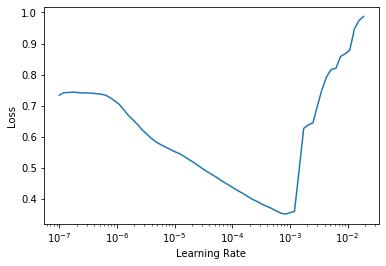

In [13]:
learn.lr_find()

In [ ]:
do_fit(learn, 20, 1e-3, freeze=False)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.135130,0.178367,0.943372,0.895749,01:56
1,0.097760,0.201101,0.942330,0.898027,01:44


In [13]:
do_fit(learn, 20, 5e-3, freeze=False)
learn.save(f'runs/{name}-1')

KeyboardInterrupt: 